In [1]:
import os
import sys
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [2]:
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [3]:
#for each tau e have = ['etOverPtLeadTrk', 'ipSigLeadTrk', 'massTrkSys', 'trFlightPathSig',
#                        'isolFrac', 'centFrac', 'dRmax', 'ClustersMeanCenterLambda', 'ClustersMeanSecondLambda']
array_tau = np.load('ntuples/datGlob_tau.npy')
print(array_tau.shape)

(7483101, 9)


### Preprocessing

In [4]:
scaler = MinMaxScaler()
scaler.fit(array_tau)
array_scaled = scaler.transform(array_tau)

In [5]:
test_percentage = 15#
test_len = math.floor(len(array_tau) * test_percentage/100)

#np.random.shuffle(array_scaled)#c'è bias altrimenti
test_scaled = array_scaled[:test_len,:]
train_scaled = array_scaled[test_len:,:]
train_labels = np.ones( len(train_scaled))
test_labels = np.ones( len(test_scaled))
print(train_scaled.shape)
print(test_scaled.shape)
print(np.max(test_scaled, axis=0))
print(np.min(test_scaled, axis=0))

(6360636, 9)
(1122465, 9)
[0.65220066 0.94679276 0.18984585 1.         0.85322585 0.71930373
 0.90700996 0.84767942 0.95725524]
[0.00000000e+00 6.56960487e-01 0.00000000e+00 0.00000000e+00
 2.80696329e-01 1.46774175e-01 8.49920900e-05 0.00000000e+00
 1.21423743e-05]


### testing the AutoEncoder

In [7]:
input_dim = 9
encoding_dim = 2
#We first build layers
input_ae = tf.keras.Input( shape=(input_dim,), name='enc_input' )
encoded = tf.keras.layers.Dense(8, activation='relu', name='enc_lay_1') (input_ae)
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu', name='enc_lay_2') (encoded)
decoded = tf.keras.layers.Dense(8, activation='relu', name='dac_lay_1') (encoded)
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid', name='dac_lay_2') (decoded) #perchè sigmoid??
#Now we build nets
autoencoder = tf.keras.Model(input_ae, decoded)
encoder = tf.keras.Model(input_ae, encoded)

input_dec = tf.keras.Input( shape=(encoding_dim) )
dec_layer_1 = autoencoder.layers[-2]
dec_layer_2 = autoencoder.layers[-1]
decoder = tf.keras.Model(input_dec, dec_layer_2(dec_layer_1(input_dec)))

In [8]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 0.1
        if epoch > 90:
            lr *= 0.1
    logging.info('Learning rate: %f'%lr)
    return lr
opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule(0))

# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'AE_on_GlobTau_LT_2.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_mean_squared_error',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
#progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler]

[2022-02-10 19:53:26,183] INFO: Learning rate: 0.001000


In [9]:
autoencoder.summary()
autoencoder.compile(optimizer = opt,,,,,
                   loss = tf.keras.losses.MeanSquaredError(),
                   metrics=['mean_squared_error'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       [(None, 9)]               0         
_________________________________________________________________
enc_lay_1 (Dense)            (None, 8)                 80        
_________________________________________________________________
enc_lay_2 (Dense)            (None, 2)                 18        
_________________________________________________________________
dac_lay_1 (Dense)            (None, 8)                 24        
_________________________________________________________________
dac_lay_2 (Dense)            (None, 9)                 81        
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________


In [48]:
#np.random.shuffle(train_scaled)
history = autoencoder.fit(train_scaled[:1000000],train_scaled[:1000000],
               batch_size = 128,
               epochs = 100,
               shuffle=True,
               validation_data = (test_scaled[:20000],test_scaled[:20000]),
               callbacks=callbacks)
#

[2022-02-10 11:40:07,367] INFO: Learning rate: 0.001000


Epoch 1/100
7813/7813 [==============================] - 28s 4ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 5.8785e-04 - val_mean_squared_error: 5.8785e-04


[2022-02-10 11:40:35,287] INFO: Learning rate: 0.001000



Epoch 00001: val_mean_squared_error improved from inf to 0.00059, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 2/100
7813/7813 [==============================] - 27s 4ms/step - loss: 4.9127e-04 - mean_squared_error: 4.9127e-04 - val_loss: 4.4016e-04 - val_mean_squared_error: 4.4016e-04


[2022-02-10 11:41:02,713] INFO: Learning rate: 0.001000



Epoch 00002: val_mean_squared_error improved from 0.00059 to 0.00044, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 3/100
7813/7813 [==============================] - 27s 4ms/step - loss: 3.6517e-04 - mean_squared_error: 3.6517e-04 - val_loss: 3.2919e-04 - val_mean_squared_error: 3.2919e-04


[2022-02-10 11:41:30,192] INFO: Learning rate: 0.001000



Epoch 00003: val_mean_squared_error improved from 0.00044 to 0.00033, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 4/100
7813/7813 [==============================] - 28s 4ms/step - loss: 3.2590e-04 - mean_squared_error: 3.2590e-04 - val_loss: 3.1278e-04 - val_mean_squared_error: 3.1278e-04


[2022-02-10 11:41:57,894] INFO: Learning rate: 0.001000



Epoch 00004: val_mean_squared_error improved from 0.00033 to 0.00031, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 5/100
7813/7813 [==============================] - 27s 4ms/step - loss: 3.1626e-04 - mean_squared_error: 3.1626e-04 - val_loss: 3.0577e-04 - val_mean_squared_error: 3.0577e-04


[2022-02-10 11:42:25,345] INFO: Learning rate: 0.001000



Epoch 00005: val_mean_squared_error improved from 0.00031 to 0.00031, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 6/100
7813/7813 [==============================] - 28s 4ms/step - loss: 3.1176e-04 - mean_squared_error: 3.1176e-04 - val_loss: 2.9997e-04 - val_mean_squared_error: 2.9997e-04


[2022-02-10 11:42:52,953] INFO: Learning rate: 0.000100



Epoch 00006: val_mean_squared_error improved from 0.00031 to 0.00030, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 7/100
7813/7813 [==============================] - 27s 4ms/step - loss: 3.0763e-04 - mean_squared_error: 3.0763e-04 - val_loss: 3.0010e-04 - val_mean_squared_error: 3.0010e-04


[2022-02-10 11:43:20,322] INFO: Learning rate: 0.000100



Epoch 00007: val_mean_squared_error did not improve from 0.00030
Epoch 8/100
7813/7813 [==============================] - 27s 3ms/step - loss: 3.0717e-04 - mean_squared_error: 3.0717e-04 - val_loss: 2.9929e-04 - val_mean_squared_error: 2.9929e-04


[2022-02-10 11:43:47,532] INFO: Learning rate: 0.000100



Epoch 00008: val_mean_squared_error improved from 0.00030 to 0.00030, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 9/100
7813/7813 [==============================] - 28s 4ms/step - loss: 3.0674e-04 - mean_squared_error: 3.0674e-04 - val_loss: 2.9824e-04 - val_mean_squared_error: 2.9824e-04


[2022-02-10 11:44:15,133] INFO: Learning rate: 0.000100



Epoch 00009: val_mean_squared_error improved from 0.00030 to 0.00030, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 10/100
7813/7813 [==============================] - 27s 3ms/step - loss: 3.0630e-04 - mean_squared_error: 3.0630e-04 - val_loss: 2.9822e-04 - val_mean_squared_error: 2.9822e-04


[2022-02-10 11:44:42,459] INFO: Learning rate: 0.000100



Epoch 00010: val_mean_squared_error improved from 0.00030 to 0.00030, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 11/100
7813/7813 [==============================] - 27s 3ms/step - loss: 3.0505e-04 - mean_squared_error: 3.0505e-04 - val_loss: 2.9582e-04 - val_mean_squared_error: 2.9582e-04


[2022-02-10 11:45:09,431] INFO: Learning rate: 0.000100



Epoch 00011: val_mean_squared_error improved from 0.00030 to 0.00030, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 12/100
7813/7813 [==============================] - 27s 4ms/step - loss: 3.0263e-04 - mean_squared_error: 3.0263e-04 - val_loss: 2.9354e-04 - val_mean_squared_error: 2.9354e-04


[2022-02-10 11:45:36,904] INFO: Learning rate: 0.000100



Epoch 00012: val_mean_squared_error improved from 0.00030 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 13/100
7813/7813 [==============================] - 27s 4ms/step - loss: 3.0087e-04 - mean_squared_error: 3.0087e-04 - val_loss: 2.9311e-04 - val_mean_squared_error: 2.9311e-04


[2022-02-10 11:46:04,368] INFO: Learning rate: 0.000100



Epoch 00013: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 14/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9968e-04 - mean_squared_error: 2.9968e-04 - val_loss: 2.9117e-04 - val_mean_squared_error: 2.9117e-04


[2022-02-10 11:46:31,690] INFO: Learning rate: 0.000100



Epoch 00014: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 15/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9873e-04 - mean_squared_error: 2.9873e-04 - val_loss: 2.9084e-04 - val_mean_squared_error: 2.9084e-04


[2022-02-10 11:46:58,839] INFO: Learning rate: 0.000100



Epoch 00015: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 16/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9791e-04 - mean_squared_error: 2.9791e-04 - val_loss: 2.9094e-04 - val_mean_squared_error: 2.9094e-04


[2022-02-10 11:47:25,925] INFO: Learning rate: 0.000100



Epoch 00016: val_mean_squared_error did not improve from 0.00029
Epoch 17/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9721e-04 - mean_squared_error: 2.9721e-04 - val_loss: 2.9076e-04 - val_mean_squared_error: 2.9076e-04


[2022-02-10 11:47:53,207] INFO: Learning rate: 0.000100



Epoch 00017: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 18/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9657e-04 - mean_squared_error: 2.9657e-04 - val_loss: 2.8903e-04 - val_mean_squared_error: 2.8903e-04


[2022-02-10 11:48:20,263] INFO: Learning rate: 0.000100



Epoch 00018: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 19/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9600e-04 - mean_squared_error: 2.9600e-04 - val_loss: 2.8856e-04 - val_mean_squared_error: 2.8856e-04


[2022-02-10 11:48:47,167] INFO: Learning rate: 0.000100



Epoch 00019: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 20/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9549e-04 - mean_squared_error: 2.9549e-04 - val_loss: 2.8821e-04 - val_mean_squared_error: 2.8821e-04


[2022-02-10 11:49:14,429] INFO: Learning rate: 0.000100



Epoch 00020: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 21/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9498e-04 - mean_squared_error: 2.9498e-04 - val_loss: 2.8885e-04 - val_mean_squared_error: 2.8885e-04


[2022-02-10 11:49:41,612] INFO: Learning rate: 0.000100



Epoch 00021: val_mean_squared_error did not improve from 0.00029
Epoch 22/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9452e-04 - mean_squared_error: 2.9452e-04 - val_loss: 2.8722e-04 - val_mean_squared_error: 2.8722e-04


[2022-02-10 11:50:08,286] INFO: Learning rate: 0.000100



Epoch 00022: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 23/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.9406e-04 - mean_squared_error: 2.9406e-04 - val_loss: 2.8781e-04 - val_mean_squared_error: 2.8781e-04


[2022-02-10 11:50:34,112] INFO: Learning rate: 0.000100



Epoch 00023: val_mean_squared_error did not improve from 0.00029
Epoch 24/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9362e-04 - mean_squared_error: 2.9362e-04 - val_loss: 2.8690e-04 - val_mean_squared_error: 2.8690e-04


[2022-02-10 11:51:01,265] INFO: Learning rate: 0.000100



Epoch 00024: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 25/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9317e-04 - mean_squared_error: 2.9317e-04 - val_loss: 2.8656e-04 - val_mean_squared_error: 2.8656e-04


[2022-02-10 11:51:28,302] INFO: Learning rate: 0.000100



Epoch 00025: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 26/100
7813/7813 [==============================] - 28s 4ms/step - loss: 2.9276e-04 - mean_squared_error: 2.9276e-04 - val_loss: 2.8676e-04 - val_mean_squared_error: 2.8676e-04


[2022-02-10 11:51:55,896] INFO: Learning rate: 0.000100



Epoch 00026: val_mean_squared_error did not improve from 0.00029
Epoch 27/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9235e-04 - mean_squared_error: 2.9235e-04 - val_loss: 2.8592e-04 - val_mean_squared_error: 2.8592e-04


[2022-02-10 11:52:23,264] INFO: Learning rate: 0.000100



Epoch 00027: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 28/100
7813/7813 [==============================] - 27s 4ms/step - loss: 2.9198e-04 - mean_squared_error: 2.9198e-04 - val_loss: 2.8570e-04 - val_mean_squared_error: 2.8570e-04


[2022-02-10 11:52:50,706] INFO: Learning rate: 0.000100



Epoch 00028: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 29/100
7813/7813 [==============================] - 28s 4ms/step - loss: 2.9162e-04 - mean_squared_error: 2.9162e-04 - val_loss: 2.8549e-04 - val_mean_squared_error: 2.8549e-04


[2022-02-10 11:53:18,402] INFO: Learning rate: 0.000100



Epoch 00029: val_mean_squared_error improved from 0.00029 to 0.00029, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 30/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9129e-04 - mean_squared_error: 2.9129e-04 - val_loss: 2.8557e-04 - val_mean_squared_error: 2.8557e-04


[2022-02-10 11:53:45,604] INFO: Learning rate: 0.000100



Epoch 00030: val_mean_squared_error did not improve from 0.00029
Epoch 31/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9098e-04 - mean_squared_error: 2.9098e-04 - val_loss: 2.8487e-04 - val_mean_squared_error: 2.8487e-04


[2022-02-10 11:54:12,805] INFO: Learning rate: 0.000100



Epoch 00031: val_mean_squared_error improved from 0.00029 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 32/100
7813/7813 [==============================] - 28s 4ms/step - loss: 2.9069e-04 - mean_squared_error: 2.9069e-04 - val_loss: 2.8460e-04 - val_mean_squared_error: 2.8460e-04


[2022-02-10 11:54:40,487] INFO: Learning rate: 0.000100



Epoch 00032: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 33/100
7813/7813 [==============================] - 27s 4ms/step - loss: 2.9041e-04 - mean_squared_error: 2.9041e-04 - val_loss: 2.8374e-04 - val_mean_squared_error: 2.8374e-04


[2022-02-10 11:55:07,993] INFO: Learning rate: 0.000100



Epoch 00033: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 34/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.9015e-04 - mean_squared_error: 2.9015e-04 - val_loss: 2.8417e-04 - val_mean_squared_error: 2.8417e-04


[2022-02-10 11:55:34,853] INFO: Learning rate: 0.000100



Epoch 00034: val_mean_squared_error did not improve from 0.00028
Epoch 35/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8990e-04 - mean_squared_error: 2.8990e-04 - val_loss: 2.8403e-04 - val_mean_squared_error: 2.8403e-04


[2022-02-10 11:56:01,449] INFO: Learning rate: 0.000100



Epoch 00035: val_mean_squared_error did not improve from 0.00028
Epoch 36/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8967e-04 - mean_squared_error: 2.8967e-04 - val_loss: 2.8396e-04 - val_mean_squared_error: 2.8396e-04


[2022-02-10 11:56:27,289] INFO: Learning rate: 0.000100



Epoch 00036: val_mean_squared_error did not improve from 0.00028
Epoch 37/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8945e-04 - mean_squared_error: 2.8945e-04 - val_loss: 2.8415e-04 - val_mean_squared_error: 2.8415e-04


[2022-02-10 11:56:53,595] INFO: Learning rate: 0.000100



Epoch 00037: val_mean_squared_error did not improve from 0.00028
Epoch 38/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8924e-04 - mean_squared_error: 2.8924e-04 - val_loss: 2.8378e-04 - val_mean_squared_error: 2.8378e-04


[2022-02-10 11:57:19,826] INFO: Learning rate: 0.000100



Epoch 00038: val_mean_squared_error did not improve from 0.00028
Epoch 39/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8906e-04 - mean_squared_error: 2.8906e-04 - val_loss: 2.8350e-04 - val_mean_squared_error: 2.8350e-04


[2022-02-10 11:57:46,305] INFO: Learning rate: 0.000100



Epoch 00039: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 40/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8887e-04 - mean_squared_error: 2.8887e-04 - val_loss: 2.8347e-04 - val_mean_squared_error: 2.8347e-04


[2022-02-10 11:58:12,833] INFO: Learning rate: 0.000100



Epoch 00040: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 41/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8869e-04 - mean_squared_error: 2.8869e-04 - val_loss: 2.8337e-04 - val_mean_squared_error: 2.8337e-04


[2022-02-10 11:58:39,701] INFO: Learning rate: 0.000100



Epoch 00041: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 42/100
7813/7813 [==============================] - 27s 4ms/step - loss: 2.8853e-04 - mean_squared_error: 2.8853e-04 - val_loss: 2.8294e-04 - val_mean_squared_error: 2.8294e-04


[2022-02-10 11:59:07,187] INFO: Learning rate: 0.000100



Epoch 00042: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 43/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8838e-04 - mean_squared_error: 2.8838e-04 - val_loss: 2.8368e-04 - val_mean_squared_error: 2.8368e-04


[2022-02-10 11:59:34,405] INFO: Learning rate: 0.000100



Epoch 00043: val_mean_squared_error did not improve from 0.00028
Epoch 44/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8822e-04 - mean_squared_error: 2.8822e-04 - val_loss: 2.8228e-04 - val_mean_squared_error: 2.8228e-04


[2022-02-10 12:00:01,762] INFO: Learning rate: 0.000100



Epoch 00044: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 45/100
7813/7813 [==============================] - 27s 4ms/step - loss: 2.8809e-04 - mean_squared_error: 2.8809e-04 - val_loss: 2.8261e-04 - val_mean_squared_error: 2.8261e-04


[2022-02-10 12:00:29,225] INFO: Learning rate: 0.000100



Epoch 00045: val_mean_squared_error did not improve from 0.00028
Epoch 46/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8795e-04 - mean_squared_error: 2.8795e-04 - val_loss: 2.8273e-04 - val_mean_squared_error: 2.8273e-04


[2022-02-10 12:00:56,252] INFO: Learning rate: 0.000100



Epoch 00046: val_mean_squared_error did not improve from 0.00028
Epoch 47/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8781e-04 - mean_squared_error: 2.8781e-04 - val_loss: 2.8193e-04 - val_mean_squared_error: 2.8193e-04


[2022-02-10 12:01:22,808] INFO: Learning rate: 0.000100



Epoch 00047: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 48/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8770e-04 - mean_squared_error: 2.8770e-04 - val_loss: 2.8224e-04 - val_mean_squared_error: 2.8224e-04


[2022-02-10 12:01:49,379] INFO: Learning rate: 0.000100



Epoch 00048: val_mean_squared_error did not improve from 0.00028
Epoch 49/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8758e-04 - mean_squared_error: 2.8758e-04 - val_loss: 2.8228e-04 - val_mean_squared_error: 2.8228e-04


[2022-02-10 12:02:16,541] INFO: Learning rate: 0.000100



Epoch 00049: val_mean_squared_error did not improve from 0.00028
Epoch 50/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8748e-04 - mean_squared_error: 2.8748e-04 - val_loss: 2.8123e-04 - val_mean_squared_error: 2.8123e-04


[2022-02-10 12:02:42,998] INFO: Learning rate: 0.000100



Epoch 00050: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 51/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8737e-04 - mean_squared_error: 2.8737e-04 - val_loss: 2.8174e-04 - val_mean_squared_error: 2.8174e-04


[2022-02-10 12:03:09,561] INFO: Learning rate: 0.000100



Epoch 00051: val_mean_squared_error did not improve from 0.00028
Epoch 52/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8727e-04 - mean_squared_error: 2.8727e-04 - val_loss: 2.8164e-04 - val_mean_squared_error: 2.8164e-04


[2022-02-10 12:03:36,554] INFO: Learning rate: 0.000100



Epoch 00052: val_mean_squared_error did not improve from 0.00028
Epoch 53/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8716e-04 - mean_squared_error: 2.8716e-04 - val_loss: 2.8245e-04 - val_mean_squared_error: 2.8245e-04


[2022-02-10 12:04:03,696] INFO: Learning rate: 0.000100



Epoch 00053: val_mean_squared_error did not improve from 0.00028
Epoch 54/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8709e-04 - mean_squared_error: 2.8709e-04 - val_loss: 2.8143e-04 - val_mean_squared_error: 2.8143e-04


[2022-02-10 12:04:30,123] INFO: Learning rate: 0.000100



Epoch 00054: val_mean_squared_error did not improve from 0.00028
Epoch 55/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8698e-04 - mean_squared_error: 2.8698e-04 - val_loss: 2.8191e-04 - val_mean_squared_error: 2.8191e-04


[2022-02-10 12:04:56,428] INFO: Learning rate: 0.000100



Epoch 00055: val_mean_squared_error did not improve from 0.00028
Epoch 56/100
7813/7813 [==============================] - 25s 3ms/step - loss: 2.8690e-04 - mean_squared_error: 2.8690e-04 - val_loss: 2.8152e-04 - val_mean_squared_error: 2.8152e-04


[2022-02-10 12:05:21,919] INFO: Learning rate: 0.000100



Epoch 00056: val_mean_squared_error did not improve from 0.00028
Epoch 57/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8682e-04 - mean_squared_error: 2.8682e-04 - val_loss: 2.8155e-04 - val_mean_squared_error: 2.8155e-04


[2022-02-10 12:05:47,970] INFO: Learning rate: 0.000100



Epoch 00057: val_mean_squared_error did not improve from 0.00028
Epoch 58/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8676e-04 - mean_squared_error: 2.8676e-04 - val_loss: 2.8199e-04 - val_mean_squared_error: 2.8199e-04


[2022-02-10 12:06:14,800] INFO: Learning rate: 0.000100



Epoch 00058: val_mean_squared_error did not improve from 0.00028
Epoch 59/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8668e-04 - mean_squared_error: 2.8668e-04 - val_loss: 2.8091e-04 - val_mean_squared_error: 2.8091e-04


[2022-02-10 12:06:41,750] INFO: Learning rate: 0.000100



Epoch 00059: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 60/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8660e-04 - mean_squared_error: 2.8660e-04 - val_loss: 2.8119e-04 - val_mean_squared_error: 2.8119e-04


[2022-02-10 12:07:08,864] INFO: Learning rate: 0.000100



Epoch 00060: val_mean_squared_error did not improve from 0.00028
Epoch 61/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8653e-04 - mean_squared_error: 2.8653e-04 - val_loss: 2.8078e-04 - val_mean_squared_error: 2.8078e-04


[2022-02-10 12:07:36,082] INFO: Learning rate: 0.000100



Epoch 00061: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 62/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8646e-04 - mean_squared_error: 2.8646e-04 - val_loss: 2.8034e-04 - val_mean_squared_error: 2.8034e-04


[2022-02-10 12:08:02,824] INFO: Learning rate: 0.000100



Epoch 00062: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 63/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8640e-04 - mean_squared_error: 2.8640e-04 - val_loss: 2.8030e-04 - val_mean_squared_error: 2.8030e-04


[2022-02-10 12:08:29,690] INFO: Learning rate: 0.000100



Epoch 00063: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 64/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8633e-04 - mean_squared_error: 2.8633e-04 - val_loss: 2.8052e-04 - val_mean_squared_error: 2.8052e-04


[2022-02-10 12:08:56,703] INFO: Learning rate: 0.000100



Epoch 00064: val_mean_squared_error did not improve from 0.00028
Epoch 65/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8626e-04 - mean_squared_error: 2.8626e-04 - val_loss: 2.8080e-04 - val_mean_squared_error: 2.8080e-04


[2022-02-10 12:09:23,913] INFO: Learning rate: 0.000100



Epoch 00065: val_mean_squared_error did not improve from 0.00028
Epoch 66/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8620e-04 - mean_squared_error: 2.8620e-04 - val_loss: 2.8106e-04 - val_mean_squared_error: 2.8106e-04


[2022-02-10 12:09:50,768] INFO: Learning rate: 0.000100



Epoch 00066: val_mean_squared_error did not improve from 0.00028
Epoch 67/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8616e-04 - mean_squared_error: 2.8616e-04 - val_loss: 2.8134e-04 - val_mean_squared_error: 2.8134e-04


[2022-02-10 12:10:17,479] INFO: Learning rate: 0.000100



Epoch 00067: val_mean_squared_error did not improve from 0.00028
Epoch 68/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8609e-04 - mean_squared_error: 2.8609e-04 - val_loss: 2.8031e-04 - val_mean_squared_error: 2.8031e-04


[2022-02-10 12:10:44,365] INFO: Learning rate: 0.000100



Epoch 00068: val_mean_squared_error did not improve from 0.00028
Epoch 69/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8602e-04 - mean_squared_error: 2.8602e-04 - val_loss: 2.8007e-04 - val_mean_squared_error: 2.8007e-04


[2022-02-10 12:11:11,412] INFO: Learning rate: 0.000100



Epoch 00069: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 70/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8598e-04 - mean_squared_error: 2.8598e-04 - val_loss: 2.8031e-04 - val_mean_squared_error: 2.8031e-04


[2022-02-10 12:11:38,751] INFO: Learning rate: 0.000100



Epoch 00070: val_mean_squared_error did not improve from 0.00028
Epoch 71/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8593e-04 - mean_squared_error: 2.8593e-04 - val_loss: 2.8036e-04 - val_mean_squared_error: 2.8036e-04


[2022-02-10 12:12:05,335] INFO: Learning rate: 0.000100



Epoch 00071: val_mean_squared_error did not improve from 0.00028
Epoch 72/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8589e-04 - mean_squared_error: 2.8589e-04 - val_loss: 2.8116e-04 - val_mean_squared_error: 2.8116e-04


[2022-02-10 12:12:32,525] INFO: Learning rate: 0.000100



Epoch 00072: val_mean_squared_error did not improve from 0.00028
Epoch 73/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8585e-04 - mean_squared_error: 2.8585e-04 - val_loss: 2.8134e-04 - val_mean_squared_error: 2.8134e-04


[2022-02-10 12:12:58,987] INFO: Learning rate: 0.000100



Epoch 00073: val_mean_squared_error did not improve from 0.00028
Epoch 74/100
7813/7813 [==============================] - 28s 4ms/step - loss: 2.8580e-04 - mean_squared_error: 2.8580e-04 - val_loss: 2.8084e-04 - val_mean_squared_error: 2.8084e-04


[2022-02-10 12:13:26,558] INFO: Learning rate: 0.000100



Epoch 00074: val_mean_squared_error did not improve from 0.00028
Epoch 75/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8574e-04 - mean_squared_error: 2.8574e-04 - val_loss: 2.7966e-04 - val_mean_squared_error: 2.7966e-04


[2022-02-10 12:13:53,401] INFO: Learning rate: 0.000100



Epoch 00075: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 76/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8570e-04 - mean_squared_error: 2.8570e-04 - val_loss: 2.8011e-04 - val_mean_squared_error: 2.8011e-04


[2022-02-10 12:14:20,708] INFO: Learning rate: 0.000100



Epoch 00076: val_mean_squared_error did not improve from 0.00028
Epoch 77/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8565e-04 - mean_squared_error: 2.8565e-04 - val_loss: 2.7954e-04 - val_mean_squared_error: 2.7954e-04


[2022-02-10 12:14:47,678] INFO: Learning rate: 0.000100



Epoch 00077: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 78/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8560e-04 - mean_squared_error: 2.8560e-04 - val_loss: 2.8018e-04 - val_mean_squared_error: 2.8018e-04


[2022-02-10 12:15:14,534] INFO: Learning rate: 0.000100



Epoch 00078: val_mean_squared_error did not improve from 0.00028
Epoch 79/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8556e-04 - mean_squared_error: 2.8556e-04 - val_loss: 2.8008e-04 - val_mean_squared_error: 2.8008e-04


[2022-02-10 12:15:41,291] INFO: Learning rate: 0.000100



Epoch 00079: val_mean_squared_error did not improve from 0.00028
Epoch 80/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8554e-04 - mean_squared_error: 2.8554e-04 - val_loss: 2.7996e-04 - val_mean_squared_error: 2.7996e-04


[2022-02-10 12:16:07,223] INFO: Learning rate: 0.000100



Epoch 00080: val_mean_squared_error did not improve from 0.00028
Epoch 81/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8548e-04 - mean_squared_error: 2.8548e-04 - val_loss: 2.8034e-04 - val_mean_squared_error: 2.8034e-04


[2022-02-10 12:16:33,231] INFO: Learning rate: 0.000100



Epoch 00081: val_mean_squared_error did not improve from 0.00028
Epoch 82/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8545e-04 - mean_squared_error: 2.8545e-04 - val_loss: 2.8005e-04 - val_mean_squared_error: 2.8005e-04


[2022-02-10 12:16:59,825] INFO: Learning rate: 0.000100



Epoch 00082: val_mean_squared_error did not improve from 0.00028
Epoch 83/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8541e-04 - mean_squared_error: 2.8541e-04 - val_loss: 2.7919e-04 - val_mean_squared_error: 2.7919e-04


[2022-02-10 12:17:26,848] INFO: Learning rate: 0.000100



Epoch 00083: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 84/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8537e-04 - mean_squared_error: 2.8537e-04 - val_loss: 2.7959e-04 - val_mean_squared_error: 2.7959e-04


[2022-02-10 12:17:53,557] INFO: Learning rate: 0.000100



Epoch 00084: val_mean_squared_error did not improve from 0.00028
Epoch 85/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8533e-04 - mean_squared_error: 2.8533e-04 - val_loss: 2.7919e-04 - val_mean_squared_error: 2.7919e-04


[2022-02-10 12:18:20,815] INFO: Learning rate: 0.000100



Epoch 00085: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5
Epoch 86/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8530e-04 - mean_squared_error: 2.8530e-04 - val_loss: 2.7976e-04 - val_mean_squared_error: 2.7976e-04


[2022-02-10 12:18:47,540] INFO: Learning rate: 0.000100



Epoch 00086: val_mean_squared_error did not improve from 0.00028
Epoch 87/100
7813/7813 [==============================] - 28s 4ms/step - loss: 2.8526e-04 - mean_squared_error: 2.8526e-04 - val_loss: 2.7933e-04 - val_mean_squared_error: 2.7933e-04


[2022-02-10 12:19:15,382] INFO: Learning rate: 0.000100



Epoch 00087: val_mean_squared_error did not improve from 0.00028
Epoch 88/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8524e-04 - mean_squared_error: 2.8524e-04 - val_loss: 2.7991e-04 - val_mean_squared_error: 2.7991e-04


[2022-02-10 12:19:42,384] INFO: Learning rate: 0.000100



Epoch 00088: val_mean_squared_error did not improve from 0.00028
Epoch 89/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8520e-04 - mean_squared_error: 2.8520e-04 - val_loss: 2.7928e-04 - val_mean_squared_error: 2.7928e-04


[2022-02-10 12:20:09,538] INFO: Learning rate: 0.000100



Epoch 00089: val_mean_squared_error did not improve from 0.00028
Epoch 90/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8517e-04 - mean_squared_error: 2.8517e-04 - val_loss: 2.7993e-04 - val_mean_squared_error: 2.7993e-04


[2022-02-10 12:20:36,733] INFO: Learning rate: 0.000100



Epoch 00090: val_mean_squared_error did not improve from 0.00028
Epoch 91/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8513e-04 - mean_squared_error: 2.8513e-04 - val_loss: 2.7975e-04 - val_mean_squared_error: 2.7975e-04


[2022-02-10 12:21:04,049] INFO: Learning rate: 0.000010



Epoch 00091: val_mean_squared_error did not improve from 0.00028
Epoch 92/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8489e-04 - mean_squared_error: 2.8489e-04 - val_loss: 2.7936e-04 - val_mean_squared_error: 2.7936e-04


[2022-02-10 12:21:30,888] INFO: Learning rate: 0.000010



Epoch 00092: val_mean_squared_error did not improve from 0.00028
Epoch 93/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8488e-04 - mean_squared_error: 2.8488e-04 - val_loss: 2.7932e-04 - val_mean_squared_error: 2.7932e-04


[2022-02-10 12:21:57,739] INFO: Learning rate: 0.000010



Epoch 00093: val_mean_squared_error did not improve from 0.00028
Epoch 94/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8488e-04 - mean_squared_error: 2.8488e-04 - val_loss: 2.7957e-04 - val_mean_squared_error: 2.7957e-04


[2022-02-10 12:22:24,924] INFO: Learning rate: 0.000010



Epoch 00094: val_mean_squared_error did not improve from 0.00028
Epoch 95/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8487e-04 - mean_squared_error: 2.8487e-04 - val_loss: 2.7938e-04 - val_mean_squared_error: 2.7938e-04


[2022-02-10 12:22:51,698] INFO: Learning rate: 0.000010



Epoch 00095: val_mean_squared_error did not improve from 0.00028
Epoch 96/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8487e-04 - mean_squared_error: 2.8487e-04 - val_loss: 2.7965e-04 - val_mean_squared_error: 2.7965e-04


[2022-02-10 12:23:18,385] INFO: Learning rate: 0.000010



Epoch 00096: val_mean_squared_error did not improve from 0.00028
Epoch 97/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8487e-04 - mean_squared_error: 2.8487e-04 - val_loss: 2.7967e-04 - val_mean_squared_error: 2.7967e-04


[2022-02-10 12:23:45,144] INFO: Learning rate: 0.000010



Epoch 00097: val_mean_squared_error did not improve from 0.00028
Epoch 98/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8487e-04 - mean_squared_error: 2.8487e-04 - val_loss: 2.7926e-04 - val_mean_squared_error: 2.7926e-04


[2022-02-10 12:24:12,466] INFO: Learning rate: 0.000010



Epoch 00098: val_mean_squared_error did not improve from 0.00028
Epoch 99/100
7813/7813 [==============================] - 27s 3ms/step - loss: 2.8486e-04 - mean_squared_error: 2.8486e-04 - val_loss: 2.7971e-04 - val_mean_squared_error: 2.7971e-04


[2022-02-10 12:24:38,986] INFO: Learning rate: 0.000010



Epoch 00099: val_mean_squared_error did not improve from 0.00028
Epoch 100/100
7813/7813 [==============================] - 26s 3ms/step - loss: 2.8485e-04 - mean_squared_error: 2.8485e-04 - val_loss: 2.7919e-04 - val_mean_squared_error: 2.7919e-04

Epoch 00100: val_mean_squared_error improved from 0.00028 to 0.00028, saving model to model_checkpoints/AE_on_GlobTau_LT_2.h5


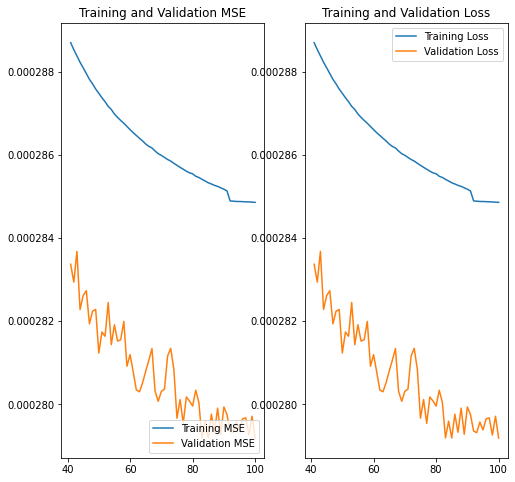

In [49]:
loss=history.history['loss']
val_loss=history.history['val_loss']

mae = history.history['mean_squared_error']
val_mae = history.history['val_mean_squared_error']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range[40:], mae[40:], label='Training MSE')
plt.plot(epochs_range[40:], val_mae[40:], label='Validation MSE')
plt.legend(loc='lower right')
plt.title('Training and Validation MSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range[40:], loss[40:], label='Training Loss')
plt.plot(epochs_range[40:], val_loss[40:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
autoencoder.load_weights("model_checkpoints/AE_on_GlobTau_LT_2.h5")

In [11]:
autoencoder.evaluate(test_scaled[100000:300000],test_scaled[100000:300000])

2022-02-10 19:53:43.031997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  93/6250 [..............................] - ETA: 10s - loss: 2.7630e-04 - mean_squared_error: 2.7630e-04 

2022-02-10 19:53:44.170688: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6250/6250 [==============================] - 12s 2ms/step - loss: 2.8068e-04 - mean_squared_error: 2.8068e-04


[0.00028068083338439465, 0.00028068083338439465]

### Print and compare outputs

In [12]:
test_pred = autoencoder.predict(test_scaled[100000:300000])
print(type(test_pred))

<class 'numpy.ndarray'>


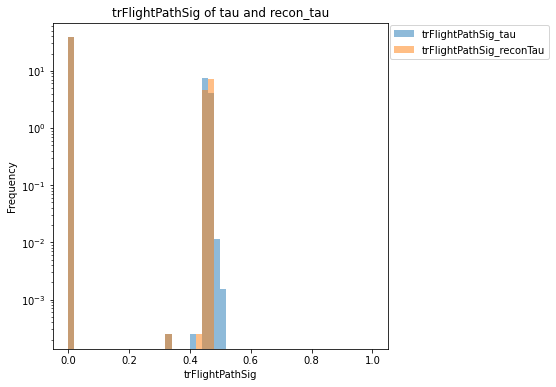

In [38]:
set_variable = ['etOverPtLeadTrk', 'ipSigLeadTrk', 'massTrkSys', 'trFlightPathSig',
                'isolFrac', 'centFrac', 'dRmax', 'ClustersMeanCenterLambda', 'ClustersMeanSecondLambda']
xlow = [0, 0, 0, 0, 0, 0, 0, 0, 0]
xup = [1, 1, 1, 1, 1, 1, 1, 1, 1]
setted_var = 3 #btw 0 and 8
n_bins=50
fig=plt.figure(figsize=(6, 6))
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
ax.hist(test_scaled[100000:300000,setted_var], bins=n_bins , label=set_variable[setted_var]+'_tau', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]])
ax1.hist(test_pred[:,setted_var], bins=n_bins , label=set_variable[setted_var]+'_reconTau', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
plt.title(set_variable[setted_var]+" of tau and recon_tau")
plt.xlabel(set_variable[setted_var])
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
ax.set_yscale('log')
ax1.set_yscale('log')

<class 'numpy.ndarray'>
(900000, 2)


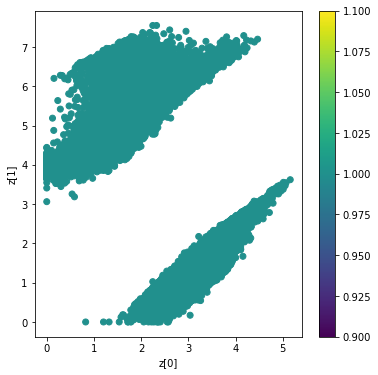

In [24]:
test_encoded = encoder.predict(test_scaled[100000:1000000], batch_size=64)
print(type(test_encoded))
print(test_encoded.shape)
plt.figure(figsize=(6, 6))
plt.scatter(test_encoded[:, 0], test_encoded[:, 1], c=test_labels[100000:1000000])
#plt.plot(test_encoded[:, 0])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

### Analize the two 'latent clusters'

We before need to generate latent code in desired areas

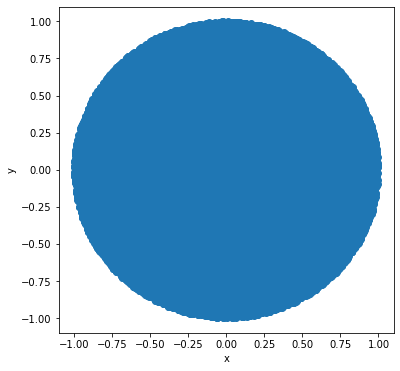

In [25]:
r = np.random.uniform(low=0.0, high=1.0, size=100000)#the external points a less probable
phi = np.random.uniform(low=0.0, high=1.0, size=100000) * 2 * np.pi

x = r * np.cos(phi)
y = r * np.sin(phi)

plt.figure(figsize=(6, 6))
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

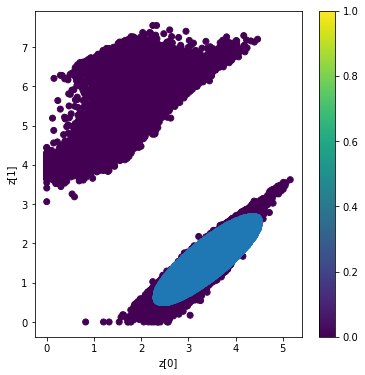

In [28]:
a = 1.50 #ad cchio, metà del lato lungo
b = 0.4
theta = 0.785398#rad = 45 g

x_e = x*a
y_e = y*b
z1 = x_e*np.cos(theta) - y_e*np.sin(theta) + 3.4
z2 = x_e*np.sin(theta) + y_e*np.cos(theta) + 1.6

plt.figure(figsize=(6, 6))
plt.scatter(test_encoded[:, 0], test_encoded[:, 1], c=test_labels[100000:1000000])
plt.scatter(z1, z2)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [29]:
FC_code = np.ones((len(z1),2))
FC_code[:,0] = z1
FC_code[:,1] = z2
print(FC_code.shape)
firstC_pred = decoder.predict(FC_code, batch_size=64)

(100000, 2)


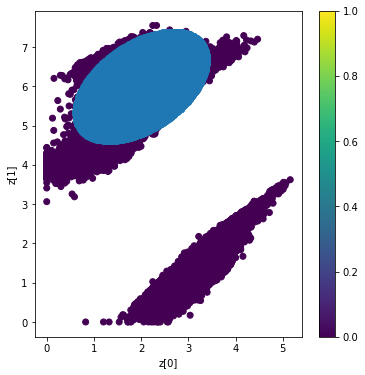

In [33]:
r = np.random.uniform(low=0.0, high=1.0, size=100000)#the external points a less probable
phi = np.random.uniform(low=0.0, high=1.0, size=100000) * 2 * np.pi

x = r * np.cos(phi)
y = r * np.sin(phi)

a = 1.70 #ad cchio, metà del lato lungo
b = 1.0
theta = 0.785398#rad = 45 g

x_e = x*a
y_e = y*b
z1 = x_e*np.cos(theta) - y_e*np.sin(theta) + 2
z2 = x_e*np.cos(theta) + y_e*np.sin(theta) + 6



plt.figure(figsize=(6, 6))
plt.scatter(test_encoded[:, 0], test_encoded[:, 1], c=test_labels[100000:1000000])
plt.scatter(z1, z2)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [31]:
SC_code = np.ones((len(z1),2))
SC_code[:,0] = z1
SC_code[:,1] = z2
print(SC_code.shape)
secondC_pred = decoder.predict(SC_code, batch_size=64)

(100000, 2)


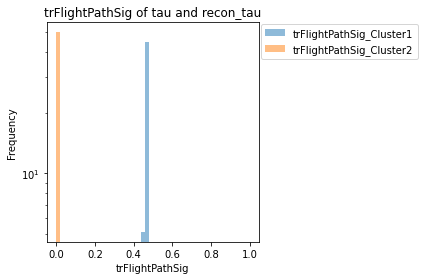

In [45]:
set_variable = ['etOverPtLeadTrk', 'ipSigLeadTrk', 'massTrkSys', 'trFlightPathSig',
                'isolFrac', 'centFrac', 'dRmax', 'ClustersMeanCenterLambda', 'ClustersMeanSecondLambda']
xlow = [0, 0, 0, 0, 0, 0, 0, 0, 0]
xup = [1, 1, 1, 1, 1, 1, 1, 1, 1]
setted_var = 3 #btw 0 and 8
n_bins=50
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
ax.hist(firstC_pred[:,setted_var], bins=n_bins , label=set_variable[setted_var]+'_Cluster1', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]])
ax1.hist(secondC_pred[:,setted_var], bins=n_bins , label=set_variable[setted_var]+'_Cluster2', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
plt.title(set_variable[setted_var]+" of tau and recon_tau")
plt.xlabel(set_variable[setted_var])
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
ax.set_yscale('log')
ax1.set_yscale('log')

### Vae

In [76]:
original_dim = 9
intermediate_dim = 8
latent_dim = 2 #= encoding_dim

inputs = tf.keras.Input(shape=(original_dim,))
h = tf.keras.layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = tf.keras.layers.Dense(latent_dim)(h)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(h)

from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = tf.keras.layers.Dense(original_dim, activation='sigmoid')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')

In [77]:
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')#, metrics=['accuracy'])

In [78]:
history = vae.fit(train_scaled[:200000], train_scaled[:200000],
        epochs=10,
        batch_size=64,
        validation_data=(test_scaled[:50000], test_scaled[:50000]))

Epoch 1/10
3125/3125 [==============================] - 13s 4ms/step - loss: 3.2188 - val_loss: 3.4878
Epoch 2/10
3125/3125 [==============================] - 13s 4ms/step - loss: 2.8908 - val_loss: 3.4712
Epoch 3/10
3125/3125 [==============================] - 12s 4ms/step - loss: 2.8866 - val_loss: 3.4909
Epoch 4/10
3125/3125 [==============================] - 12s 4ms/step - loss: 2.8859 - val_loss: 3.5052
Epoch 5/10
3125/3125 [==============================] - 12s 4ms/step - loss: 2.8851 - val_loss: 3.4936
Epoch 6/10
3125/3125 [==============================] - 12s 4ms/step - loss: 2.8845 - val_loss: 3.5073
Epoch 7/10
3125/3125 [==============================] - 12s 4ms/step - loss: 2.8834 - val_loss: 3.5148
Epoch 8/10
3125/3125 [==============================] - 13s 4ms/step - loss: 2.8822 - val_loss: 3.5222
Epoch 9/10
3125/3125 [==============================] - 13s 4ms/step - loss: 2.8799 - val_loss: 3.5004
Epoch 10/10
3125/3125 [==============================] - 13s 4ms/step - l

<IPython.core.display.Javascript object>


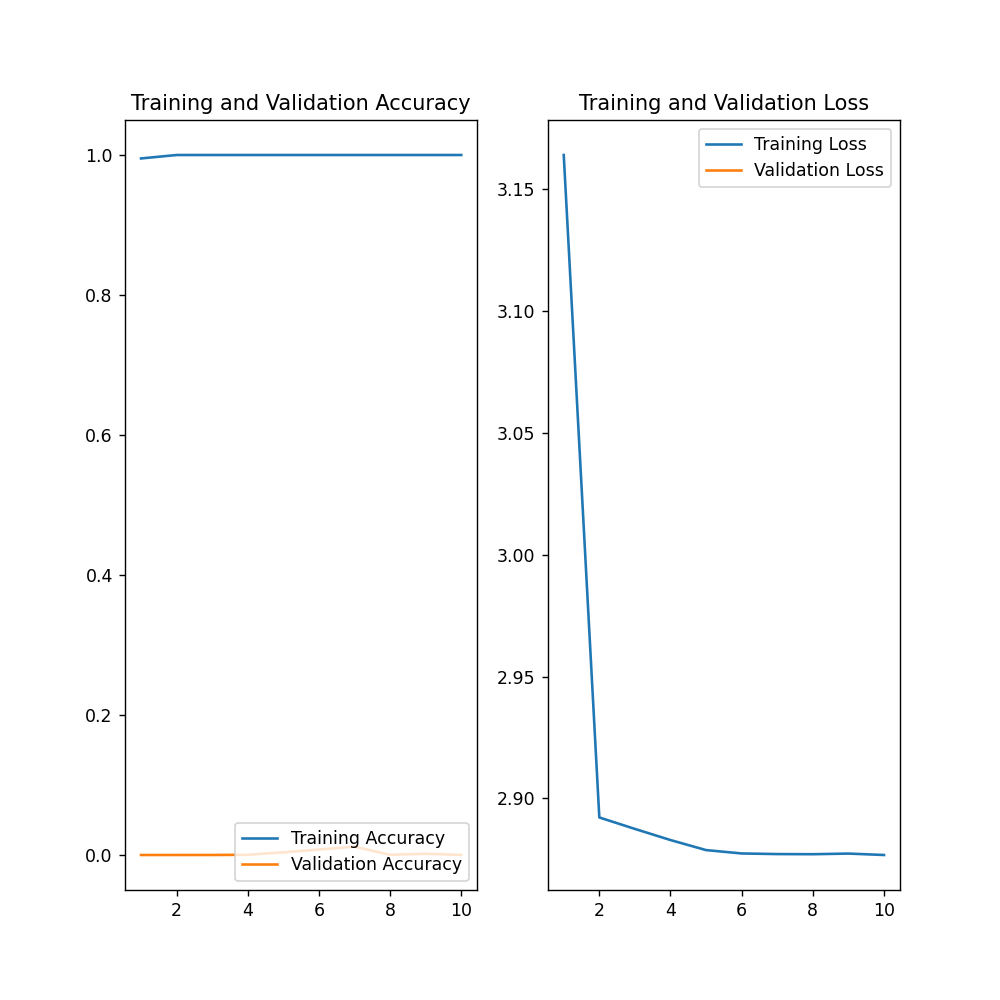

In [60]:
loss=history.history['loss']
val_loss=history.history['val_loss']

mae = history.history['accuracy']
val_mae = history.history['val_accuracy']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training Accuracy')
plt.plot(epochs_range, val_mae, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [79]:
vae.evaluate(test_scaled[100000:200000],test_scaled[100000:200000])

3125/3125 [==============================] - 9s 3ms/step - loss: 3.4851


3.4851183891296387

(3, 100000, 2)


<IPython.core.display.Javascript object>


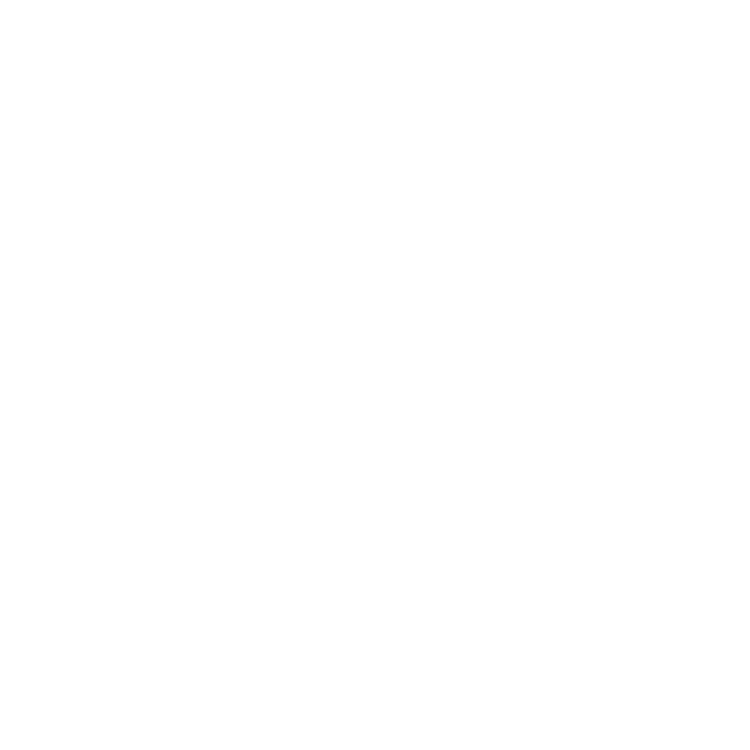

TypeError: list indices must be integers or slices, not tuple

In [80]:
x_test_encoded = encoder.predict(test_scaled[100000:200000], batch_size=64)
print(np.array(x_test_encoded).shape)
plt.figure(figsize=(6, 6))
plt.scatter(np.array(x_test_encoded[:, 0]), np.array(x_test_encoded[:, 1]), c=test_labels[100000:200000])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [81]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Esempio copiato da keras...

<class 'numpy.ndarray'>
60000
(60000, 784)
started fit...
1875/1875 [==============================] - 8s 4ms/step - loss: 187.9602 - val_loss: 167.7919
<class 'list'>
3
(3, 10000, 2)


<IPython.core.display.Javascript object>


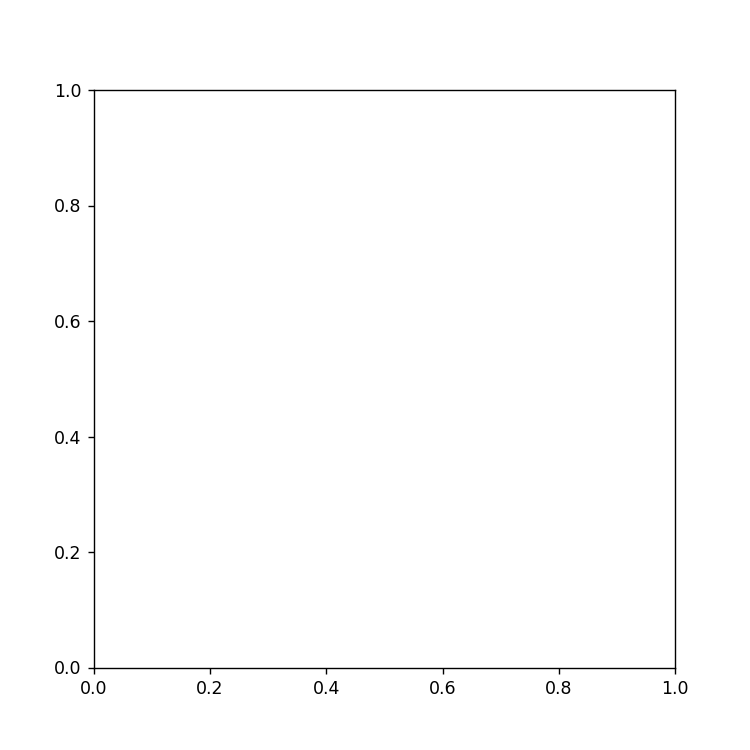

ValueError: 'c' argument has 10000 elements, which is inconsistent with 'x' and 'y' with size 6.

In [90]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

from keras import backend as K
from keras import layers

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(type(x_train))
print(len(x_train))
print(np.array(x_train).shape)
print("started fit...")
vae.fit(x_train, x_train,
        epochs=1,
        batch_size=32,
        validation_data=(x_test, x_test))

x_test_encoded = encoder.predict(x_test, batch_size=32)
print(type(x_test_encoded))
print(len(x_test_encoded))
print(np.array(x_test_encoded).shape)
plt.figure(figsize=(6, 6))
plt.scatter(np.array(x_test_encoded)[:, 0], np.array(x_test_encoded)[:, 1], c=y_test)
plt.colorbar()
plt.show()